In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from numpy.linalg import matrix_rank
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

# Random forest regressor

### Load training and label data

In [32]:
train = pd.read_csv('./../data/training.csv')
label = pd.read_csv('./../data/labels.csv', header=None)
train.drop('Unnamed: 0', axis=1, inplace=True)
# label encode type 
le = LabelEncoder()
train['type_enc'] = le.fit_transform(train['type'])
label.columns = ['0', 'p_label2']
label.drop('0', axis=1, inplace=True)
y_label = np.ravel(label)

In [33]:
train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'blockTime',
       u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward', u'size', u'type',
       u'totalFee', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_blocktime_6', u'avg_gasUsed_b_6', u'avg_tx_count_6',
       u'avg_uncle_count_6', u'avg_difficulty_6', u'avg_txcnt_second_6',
       u'avg_gasUsed_t_6', u'avg_price_6', u'avg_blocktime_60',
       u'avg_gasUsed_b_60', u'avg_tx_count_60', u'avg_uncle_count_60',
       u'avg_difficulty_60', u'avg_txcnt_second_60', u'avg_gasUsed_t_60',
       u'avg_price_60', u'mv', u'type_enc'],
      dtype='object')

### Select features

In [34]:
sub_cols = ['gasLimit_t', 
            'gasUsed_t', 
            'newContract', 
       'avg_blocktime_6', 
       'avg_uncle_count_6', 
            'avg_txcnt_second_6',
       'avg_gasUsed_t_6', 
            'avg_price_6', 
            'avg_uncle_count_60',
        'avg_price_60', 
            'mv', 
            'type_enc']

### Split the data

In [35]:
sub_train = train[sub_cols]
X = sub_train.values
y = y_label
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [36]:
matrix_rank(X), len(sub_cols)

(12, 12)

### Variance inflation factors
If the VIF is equal to 1 there is no multicollinearity among factors, but if the VIF is greater than 1, the predictors may be moderately correlated. The output above shows that the VIF for the Publication and Years factors are about 1.5, which indicates some correlation, but not enough to be overly concerned about. A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.

In [7]:
for i, col in enumerate(sub_train.columns):
    print('VIF col {}: {}'.format(col,variance_inflation_factor(X,i)))

VIF col gasLimit_t: 1.59171325219
VIF col gasUsed_t: 1.41965478479
VIF col newContract: 1.03855950223
VIF col avg_blocktime_6: 4.44493959221
VIF col avg_uncle_count_6: 1.62189618616
VIF col avg_txcnt_second_6: 2.24676473359
VIF col avg_gasUsed_t_6: 2.08424912098
VIF col avg_price_6: 2.14220672369
VIF col avg_uncle_count_60: 4.95359233193
VIF col avg_price_60: 3.6317550142
VIF col mv: 1.11936078272
VIF col type_enc: 3.34148223087


## Cross validation to find optimal model

In [37]:
rf1 = RandomForestRegressor()

In [38]:
rf1.get_params().keys()

['warm_start',
 'oob_score',
 'n_jobs',
 'min_impurity_decrease',
 'verbose',
 'max_leaf_nodes',
 'bootstrap',
 'min_samples_leaf',
 'n_estimators',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'criterion',
 'random_state',
 'min_impurity_split',
 'max_features',
 'max_depth']

### Standardize data

In [39]:
# Create a scaler object
#sc = StandardScaler()

# Fit the scaler to the feature data and transform
#X_std = sc.fit_transform(X)

### Nested cross validation

In [57]:
# Create a list of 10 candidate values for the C parameter
param_candidates = dict(max_depth=np.arange(1, 7, 1), 
                        n_estimators=np.arange(5, 25, 5))

In [58]:
param_candidates

{'max_depth': array([1, 2, 3, 4, 5, 6]),
 'n_estimators': array([ 5, 10, 15, 20])}

In [59]:
# Create a gridsearch object with the decision tree regressor and the max_depth value candidates
rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_candidates)

In [60]:
# Fit the cross validated grid search on the data 
rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5, 10, 15, 20]), 'max_depth': array([1, 2, 3, 4, 5, 6])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [61]:
# Show the best param values
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
print('Mean CV r2_score: {}'.format(np.mean(cross_val_score(
        rf, X_train, y_train, scoring='r2', cv=5))))

Mean CV r2_score: 0.84999569726


# Plot results

In [73]:
sub_train.columns

Index([u'gasLimit_t', u'gasUsed_t', u'newContract', u'avg_blocktime_6',
       u'avg_uncle_count_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'avg_uncle_count_60', u'avg_price_60', u'mv',
       u'type_enc'],
      dtype='object')

In [65]:
y_pred = rf.predict(X_test)

In [68]:
y_pred.shape, y_test.shape

((349157,), (349157,))

In [80]:
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

In [ ]:
results['y_test_log'] = 

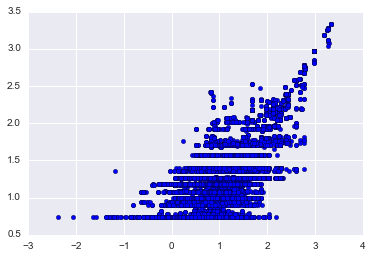

In [86]:
plt.scatter(results['y_test'].apply(np.log10), results['y_pred'].apply(np.log10))
#plt.xlim(0,100)
#plt.ylim(0,100)

In [ ]:
sns.set(style="darkgrid", color_codes=True)
sns.jointplot(x="y_test", y="y_pred", data=results, marginal_kws=dict(bins=25)
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig('./../images/jointplot.png', dpi=300)

## Feature importances

In [91]:
def rf_regressor(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=5)
    print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
    print('R2_score: {}'.format(r2_score(y_test, y_pred)))
    print('avg_CV_score: {}'.format(np.mean(scores)))
    # write predicted values to csv
    p = pd.DataFrame({'y_pred': y_pred})
    p.to_csv('./../data/label_pred.csv')
    return rf

In [92]:
model = rf_regressor(X_train, X_test, y_train, y_test)

MSE: 13.1884823058
R2_score: 0.987232856113
avg_CV_score: 0.983622505175


In [ ]:
def plot_feature_importance(rf, feature_df):
    cols = []
    for col in feature_df.columns:
        cols.append(col)

    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=cols)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    feat_scores.plot(kind='barh', color='r', figsize=(6,6))
    #plt.xlabel('Importance', fontsize=18)
    plt.title('Feature Importance', fontsize=18)
    plt.tight_layout()
    plt.savefig('./../images/feat_import_pruned.png', dpi=300)

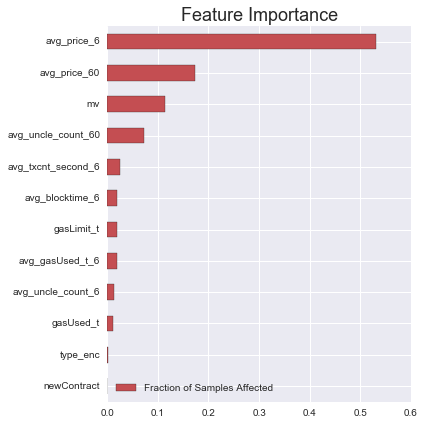

In [93]:
plot_feature_importance(model, sub_train)